In [100]:
# imports 
import os 
import tensorflow as tf 
import cv2 
import numpy
from matplotlib import pyplot as plt

# making GPU be used, and setting memory limits
gpus = tf.config.list_physical_devices('GPU')
# gpus = tf.config.list_logical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("gpu set")
except:
    pass
    print("failed")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpu set


## basic functions

In [186]:
# setting up the functions to convert from chars to num and vice versa
vocab = [x for x in "ABCDEFGHIJKLMNOPQRSTUVWXYZ "]
charToNum = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
numToChar = tf.keras.layers.StringLookup(vocabulary=charToNum.get_vocabulary(), oov_token="", invert=True)

# facial detection vars 
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
lastKnownCrop = (0, 0, 160, 150)

# data dir
rootDir = 'A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles'
rootDir2 = 'A:\Lip Reading\Potential Datasets\\BBC LRS2'
# r = "A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles"

batchSize = 2

In [187]:
# util funcs 
def faceDetection(img):
    # TROUBLESHOOTING
    # print("max size:",img.shape, img.shape[0] - 3 * padding, img.shape[1] - 3 * padding)
    return faceCascade.detectMultiScale(
        img,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(30, 30),
    )

def cropForMouth(img) -> numpy.ndarray:
    global lastKnownCrop
    rects = faceDetection(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
    # finding the largest face in a given image 
    largestFace = (0,0,0,0)
    for (x, y, w, l) in rects:
        if (w * l) > largestFace[2] * largestFace[3]:
            largestFace = (x, y,w,l)
        
    if largestFace == (0,0,0,0):
        largestFace =lastKnownCrop
    # cropping for face 
    lastKnownCrop = largestFace
    y1 = lastKnownCrop[1] 
    x1 = lastKnownCrop[0]
    y2 = y1 + lastKnownCrop[3] 
    x2 = x1 + lastKnownCrop[2]
    return img[y1 + int(0.65 * lastKnownCrop[3]): y2, x1 + int(0.05 * lastKnownCrop[2]): int(0.95 * x2)]

def numberToWords(num):  
    if num == 0:  
        return "zero"  
    ones = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]  
    tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]  
    teens = ["ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]  
    words = ""  
    if num>= 1000:  
        words += ones[num // 1000] + " thousand "  
        num %= 1000  
    if num>= 100:  
        words += ones[num // 100] + " hundred "  
        num %= 100  
    if num>= 10 and num<= 19:  
        words += teens[num - 10] + " "  
        num = 0  
    elif num>= 20:  
        words += tens[num // 10] + " "  
        num %= 10  
    if num>= 1 and num<= 9:  
        words += ones[num] + " "  
    return words.strip().upper()

In [200]:
def loadData(path): 
    # tf has the paths as bytes so decode that
    path = bytes.decode(path.numpy())
    
    # extract just the file names
    global rootDir
    fileName = path.split('\\')[-1].split('.')[0]
    # generate the respective paths of the data
    videoPath = os.path.join(rootDir,f'{fileName}.mp4')
    alignmentPath = os.path.join(rootDir,f'{fileName}.txt')
    
    # return the frames and alignments
    frames = loadVideo(videoPath) 
    alignments = loadText(alignmentPath)
    return frames, alignments

def loadVideo(path): 
    cap = cv2.VideoCapture(path)
    global lastKnownCrop
    processedFrames = []
    # for each frame 
    for n in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        
        # in case a frame is missing, just continue
        if frame is None or frame.shape[0] == 0: 
            continue
        
        # crop only the mouth like we'll do on the RPI 
        frame = cropForMouth(frame)
        frame = cv2.resize(frame, (150, 50))
        
        try: frame = tf.image.rgb_to_grayscale(frame)
        except: continue
        
        processedFrames.append(frame)
        
    cap.release()    

    # generate the normalized frames (deviation from the average) 
    mean = tf.math.reduce_mean(processedFrames)
    std = tf.math.reduce_std(tf.cast(processedFrames, tf.float32), axis=[0, 1, 2], keepdims=True)
    frames = tf.cast(processedFrames, tf.float32)
    normalizedFrames = (tf.cast(frames, tf.float32) - tf.cast(mean, tf.float32)) / tf.cast(std, tf.float32)
    return normalizedFrames

def loadText(path): 
    # open and parse the file 
    with open(path, 'r') as file: lines = file.readlines()
    file.close()
    
    # return the number equivalent of each of the characters of the word 
    tokens = []
    words = lines[0].split()
    del words[0]

    for word in words: 
        if word.isnumeric():
            newWord = numberToWords(int(word))
            words[words.index(word)] = newWord
    words = " ".join(words).split()
    
    for word in words: 
        tokens = [*tokens,' ', word]
    
    return charToNum(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]   

def processData(path): 
    return tf.py_function(loadData, [path],  (tf.float32, tf.int64))

In [201]:
def getFrameCount(path) -> int: 
    cap = cv2.VideoCapture(path)
    frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    return frameCount

def getCharCount(path) -> int: 
    return len(loadText(path))

In [202]:
numberPath = "A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\Numbers.txt"
tensorPath = tf.convert_to_tensor(numberPath, dtype=tf.string)
path = bytes.decode(tensorPath.numpy())
fileName = path.split('\\')[-1].split('.')[0]

# testing if the loadData, loadVideo, and loadText function all work
alignmentPath = os.path.join(rootDir2,f'{fileName}.txt')
loadText(alignmentPath)

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([20,  8, 18,  5,  5, 27,  8, 21, 14,  4, 18,  5,  4, 27, 20, 23, 15,
       27,  8, 21, 14,  4, 18,  5,  4], dtype=int64)>

In [203]:
rawPath = "A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\allFiles\\5535415699068794046_00001.mp4"
maxframeCt = 154
maxCharCt = 99

tensorPath = tf.convert_to_tensor(rawPath, dtype=tf.string)
path = bytes.decode(tensorPath.numpy())
fileName = path.split('\\')[-1].split('.')[0]

# testing if the loadData, loadVideo, and loadText function all work
videoPath = os.path.join(rootDir,f'{fileName}.mp4')
alignmentPath = os.path.join(rootDir,f'{fileName}.txt')

loadVideo(videoPath)
loadText(alignmentPath)

frames, text = loadData(tensorPath)
print(type(frames))
print(len(frames[0][0]))

<class 'tensorflow.python.framework.ops.EagerTensor'>
150


## reading data

In [204]:
# reading all files within the root directory
# data = tf.data.Dataset.list_files('A:\Lip Reading\Potential Datasets\BBC LRS2\mvlrs_v1\main\*\*.mp4')
data = tf.data.Dataset.list_files('A:/Lip Reading/Potential Datasets/BBC LRS2/trainFiles2/*.mp4')

data = data.shuffle(int(len(data) / 4), reshuffle_each_iteration=False) # shuffling data
data = data.map(processData) # "processing" the data to obtain frames and the respective text 

dim1 = frames.shape[1]
dim2 = frames.shape[2]
print("dataset size before padding:", len(data))
print("data shape of example video:", frames.shape)

# combining 8 videos as one "input"
# ensuring all videos are padded to match the longest video, 
# ensuring the length of all the alignments is the size of the longest text characters, as some are lower. 
data = data.padded_batch(batchSize, padded_shapes=([2*maxCharCt,dim1, dim2,1], [maxCharCt])) 
data = data.prefetch(tf.data.AUTOTUNE)
print("data length after padding:", len(data))
print("batch size:", batchSize)

train = data.take(int(len(data) * 0.9))
test = data.skip(int(len(data) * 0.9))
print("train data size:", len(train))
print("test data size:",  len(test))

dataset size before padding: 1115
data shape of example video: (35, 50, 150, 1)
data length after padding: 558
batch size: 2
train data size: 502
test data size: 56


198


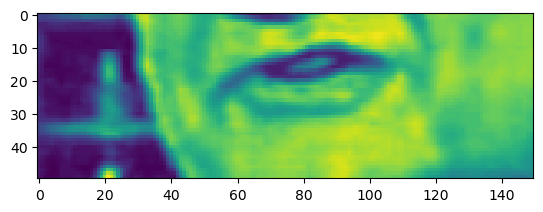

In [205]:
val = data.as_numpy_iterator().next()
plt.imshow(val[0][0][30])
print(len(val[0][0]))

In [206]:
tf.strings.reduce_join([numToChar(word) for word in val[1][0]])
print("num of chars:", len(([numToChar(word) for word in val[1][0]])))

num of chars: 99


## designing the model

In [207]:
# imports for the model architecture 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPooling3D, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [208]:
inputShape = data.as_numpy_iterator().next()[0][0].shape
print(inputShape)
print(charToNum.get_vocabulary())
print(len(charToNum.get_vocabulary()))

(198, 50, 150, 1)
['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']
28


In [209]:
# model to be actually trained
model = Sequential([
Conv3D(32, 3, input_shape=inputShape, padding='same', activation='relu'),
MaxPooling3D((1,6,10)),

Conv3D(maxframeCt, 5, padding='same', activation='relu'),

TimeDistributed(Flatten()),

Bidirectional(LSTM(16, return_sequences=True)),
Dropout(.5),

Dense(charToNum.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')
])

# model = Sequential([
# Conv3D(128, 3, input_shape=inputShape, padding='same', activation='relu'),
# MaxPooling3D((1,2,2)),
# 
# Conv3D(256, 3, padding='same', activation='relu'),
# MaxPooling3D((1,2,2)),
# 
# Conv3D(154, 3, padding='same', activation='relu'),
# MaxPooling3D((1,2,2)),
# 
# TimeDistributed(Flatten()),
# 
# Bidirectional(LSTM(128, return_sequences=True)),
# Dropout(.5),
# 
# Bidirectional(LSTM(128,  return_sequences=True)),
# Dropout(.5),
# 
# Dense(charToNum.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')
# ])

# 
# testModel = Sequential([
# Conv3D(154, 5, input_shape=inputShape, padding='same', activation='relu'),
# MaxPooling3D((1,3,5)),
#  
# TimeDistributed(Flatten()),
#     
# Dense(charToNum.vocabulary_size()+1, activation='softmax')
# ])
# 
# model3 = Sequential([
# Conv3D(32, 3, input_shape=inputShape, padding='same', activation='relu'),
# MaxPooling3D((1,2,2)),
# 
# Conv3D(64, 3, input_shape=inputShape, padding='same', activation='relu'),
# MaxPooling3D((1,2,2)),
# 
# Conv3D(154, 3, padding='same', activation='relu'),
# MaxPooling3D((1,2,2)),
# 
# TimeDistributed(Flatten()),
# 
# Bidirectional(LSTM(64, return_sequences=True)),
# Dropout(0.5),
# 
# Bidirectional(LSTM(64, return_sequences=True)),
# Dropout(0.5),
# 
# Dense(charToNum.vocabulary_size()+1, activation='softmax')
# ])

In [210]:
model.summary()
# testModel.summary()
# model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 198, 50, 150, 32)  896       
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 198, 8, 15, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 198, 8, 15, 154)   616154    
                                                                 
 time_distributed_12 (TimeDi  (None, 198, 18480)       0         
 stributed)                                                      
                                                                 
 bidirectional_12 (Bidirecti  (None, 198, 32)          2367616   
 onal)                                                           
                                                     

In [211]:
# custom functions 
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
# custom loss function 
def CTCLoss(yTrue, yPred):
    
    # y true is the text alignment (None, 99) 
    # y pred is the end result of the model (154, 41) 
    batchLen = tf.cast(tf.shape(yTrue)[0], dtype="int64")
    # print("tf.shape(yTrue)[0]:", tf.shape(yTrue)[0])
    inputLen = tf.cast(tf.shape(yPred)[1], dtype="int64")
    labelLen = tf.cast(tf.shape(yTrue)[1], dtype="int64")
    # print("initial inputlen", inputLen)
    # print("initial labellen", labelLen)

    inputLen = inputLen * tf.ones(shape=(batchLen, 1), dtype="int64")
    labelLen = labelLen * tf.ones(shape=(batchLen, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(yTrue, yPred, inputLen, labelLen)   
    # print("ytrue", yTrue)
    # print("ypred",yPred)
    # print("batchlen", batchLen)
    # print("inputlen", inputLen)
    # print("labellen",labelLen)
    # print("loss",loss)
    # print("*" * 50) 

    # return loss
    return loss 


class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        
        decoded = tf.keras.backend.ctc_decode(yhat, [maxframeCt, maxframeCt], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(numToChar(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(numToChar(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [212]:
yHat = model.predict(val[0])
print(tf.strings.reduce_join([numToChar(tf.argmax(x)) for x in yHat[0]]))
print(len(([numToChar(tf.argmax(x)) for x in yHat[0]])))

1/1 [==============================] - 1s 759ms/step
tf.Tensor(b'TGGGMGGGGGGGGGGGGGGGGMGMGGGGGGGGGGGGGGGMGGGGGGGGGGGGGGGGGGMMMMMGGGGGGGGGGGGGMMMMMMMMMMMGGGSSSMMSSSYOOYYMMMMMMMMMMGGGGGGGGFZZZNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGDDDBBB', shape=(), dtype=string)
198


In [213]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001), loss=CTCLoss)
checkpointCallback = ModelCheckpoint('newLipModelv2_m1.weights.h5', monitor='loss',save_weights_only=False) 
scheduleCallback = LearningRateScheduler(scheduler)
exampleCallback = ProduceExample(test)
# 
# model3.compile(optimizer=RMSprop(learning_rate=0.001), loss=CTCLoss)
# # checkpointCallback = ModelCheckpoint('newLipModelm3.weights.h5', monitor='loss',save_weights_only=False) 
# scheduleCallback = LearningRateScheduler(scheduler)
# # exampleCallback = ProduceExample(test)
#  
# testModel.compile(optimizer=Adam(learning_rate=0.001), loss=CTCLoss)
# scheduleCallback = LearningRateScheduler(scheduler)

In [214]:
model.fit(train, validation_data=test, epochs=100, callbacks=[scheduleCallback, checkpointCallback])

Epoch 1/100
  4/502 [..............................] - ETA: 6:17 - loss: 520.6655


KeyboardInterrupt



In [ ]:
yHat = model.predict(val[0])
print(tf.strings.reduce_join([numToChar(tf.argmax(x)) for x in yHat[0]]))

In [ ]:
model.load_weights('newLipModel_m1.weights.h5')

In [ ]:
# Get training and test loss histories
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();